之前我给大家介绍过一篇使用keras和LSTM来进行文本多分类的博客 ,今天我将在google提供的Colab notebook上使用tensorflow2.0来是实现以下中文文本多分类的实战应用。选择Colab notebook是因为在Colab notebook中google提供了免费的GPU资源供你使用，这样可以大大节省模型的训练时间。

Google Colab，全名Colaboratory，是由谷歌提供的免费的云平台，可以使用keras、tensorflow等框架进行深度学习。最近Colab平台已经将K80 GPU更换成Tesla T4 GPU，提供了更强的算力。对于刚入门机器学习或深度学习的用户，这个平台是不二之选。

要使用Google Colab必须要在科学上网的环境下，同时必须要有一个gmail账号，还没有gmail账号的同学请赶快注册一个吧。

如何使用colab请看这篇博客（https://www.cnblogs.com/lfri/p/10471852.html）


In [0]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import jieba as jb
import re

In [0]:
#如果还没有安装tensorflow2.0,请使用下面的命令安装tensorflow
#!pip install tensorflow==2.0.0

# 数据

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.0.0


In [0]:
# #加载google的云端硬盘
from google.colab import drive
drive.mount('/content/drive')

In [79]:
df = pd.read_csv('./drive/My Drive/data/online_shopping_10_cats.csv')
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 62774 .


,cat,label,review
20435,水果,1,这次购物不满意，有焉了的，感觉不怎么有水分，早知道不如直接去市场买，你们可以看看，物流给5星...
47539,衣服,0,一般般，不咋的这衣服
43047,衣服,1,宝贝收到，衣服和描述的一样，服务很好，物流很快，大小合适。
44821,衣服,0,不满意，与图片相差不多，太丑了。我都要求退货了，但是这么多天理都没人理。建议各位网友慎买这家货。
17004,水果,1,还可以啊，只是这阵价格比前面贵
60250,酒店,0,房间隔音出奇的差，从来没有住过隔音这么差的酒店，左右隔壁房间的电视、说话声音，过道里的声音在...
46321,衣服,0,衣服真垃圾。。。。。
36090,洗发水,0,特别不好用，用完头发头皮发油发尾枯
8515,平板,1,清晰度高，声音好听，速度快，支持国产
48332,衣服,0,衣服还可以，不过选的这家物流我真无语，货不给我送到地方不说，弄个存放点，第二天去取还跟我收费...


In [6]:
df[["cat"]].drop_duplicates().reset_index(drop=True)

,cat
0,书籍
1,平板
2,手机
3,水果
4,洗发水
5,热水器
6,蒙牛
7,衣服
8,计算机
9,酒店


In [7]:
print(df.cat.value_counts())
print()
print(df.cat.value_counts()/len(df));


酒店     10000
水果     10000
平板     10000
洗发水    10000
衣服     10000
计算机     3992
书籍      3851
手机      2323
蒙牛      2033
热水器      575
Name: cat, dtype: int64

酒店     0.159302
水果     0.159302
平板     0.159302
洗发水    0.159302
衣服     0.159302
计算机    0.063593
书籍     0.061347
手机     0.037006
蒙牛     0.032386
热水器    0.009160
Name: cat, dtype: float64


In [0]:
df[df.cat=='平板'][["review"]].sample(5).values

array([['东西是给78岁爷爷买的，他用的特别方便，京东配送也特别快，总之，特别满意。老人主要以看电视剧，新闻为主，标准配置已经足够了，请大家参考。'],
       ['从此再也不在京东买东西，呵呵14号下单，15号活动减300，问客服不理，好歹也给个理由回复把！申请保价说有赠品就不给保价。下单之后还给我说地址有问题不给送，要我取消订单。我以前买的东西你让鬼送过来的？虽然最后解决了，但是服务又慢又差。手机还行，但是劝大家别在这里买。本想到315投诉，但忙的都没时间。'],
       ['第一次从京东买东西，真的好坑，客服都是些大夜。最重要的是差评怎么就提交不出去呢？'],
       ['性能很不错。显示跟运行速度给力。支持国产芯！！！就是背后的弧形有点失望'],
       ['前摄像头的像素不够清晰，拍了照片会有各种黑点，问了客服人员说不是质量问题。']], dtype=object)

In [0]:
df[df.cat=='手机'][["review"]].sample(5).values

array([['1、来电显示只显示对方的姓名而不显示号码，对方可能有几个号，这样就不知道是对方的哪一个电话号码打来的？应该显示姓名+电话号码！2、我每天都要从名片夹中查找很多联系人的号码，而且他们的号码大多是长途的，所以我都是从手机中找到了再用办公室的座机拨打，因为使用次数频繁，所以使用名片夹中的查找功能很麻烦，如果通过语音拨号呼叫并且能停留在该联系人的名片资料上不直接拨打就好了，摩托A780这一点就做得比较好。'],
       ['排线容易坏我已经换了几次了啊！而且售后服务特别差'],
       ['我用了两个月，除了时间不太准之外没什么性能上的毛病。我满意的是屏幕的大小和颜色以及自动开关机的功能。'],
       ['色彩明亮，对比度好，通话质量高'],
       ['不错，功能很全，D盘下有7兆呢，可是短信满了，也只能望卡兴叹！其他都不错，有三个闹钟，阴历，等等！']],
      dtype=object)

In [0]:
df[df.cat=='酒店'][["review"]].sample(5).values

array([['预定酒店很顺利。离西街较远，房间很有特色，古色古香，下次去阳朔再住这里'],
       ['环境较差，马路噪音非常大，而且房间之间的隔音处理得不好，睡在床上能听到楼道里的讲话声。房间偏小。另外，离机场非常远。出租司机走外环线，说是速度快，但走了40多公里。饭店周围的环境很乱。'],
       ['我是在全国雪灾时来到了仁安悦榕庄的，整个酒店就我们一个住户，酒店座落在藏民的村落中，与自然环境融为一体，我看到的是一个白色的童话世界，酒店工作人员及总经理何满先生都相当的亲切，怕大雪封山，酒店派了最好的藏族司机：扎西，第二天一早送我们回了丽江，而他自己连着就回香格里拉，等于要开一天的路（早上８点３０出发，他到晚上９点才到）而'],
       ['订的是双人房,感觉房间有点小,放了两张床之后就没什么空间了,沙发也只有一个单人的.觉得最不好的是洗手间太太太小了 - 好挤,门拉直打开就到浴缸的边了.除了小的问题之外,房间还是很舒服的.自助早餐不错,很丰富,可惜吃不了多少...会所在酒店外面,觉得有点不方便. 有室内游泳池,去游泳还一定要求带游泳帽,最终没下水, 有点郁闷.'],
       ['在这个酒店住过至少有四次，进行一下简单的评价：房间的面积比较大，够得上四星的标准，只是有些房间稍旧了点；房间的设施中规中矩，还行，电脑的上网速度还可以；卫生间的花瓣很欣赏，这一点相当不错；客房服务员的态度非常好，很欣赏；总体感觉较好，推荐！！！']],
      dtype=object)

In [0]:
df[df.cat=='衣服'][["review"]].sample(5).values

array([['什么鬼东西，质量差，东西又发错，垃圾'],
       ['白色打底衫，质量不错，便宜！！！！！！！！穿着舒服！！！'],
       ['快递非常给力哦，昨天下单今天上午就到了，款式不错，大小正好，质量很好，非常满意'],
       ['纯棉的，很不错。这个价格能买到纯棉很不错了'],
       ['你*的就给我这样的裤子？特么的这是我在京东唯一一次买到烂东西，就你这家店，你老母的，老子准备过年穿的，滚你*，给你一星都奢侈']],
      dtype=object)

## 数据预处理

下面我们要对评语进行一些预处理工作,这包括删除文本中的标点符号,特殊符号,还要删除一些无意义的常用词(stopword),因为这些词和符号对系统分析预测文本的内容没有任何帮助,反而会增加计算的复杂度和增加系统开销,所有在使用这些文本数据之前必须要将它们清理干净。

In [0]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

#加载停用词
stopwords = stopwordslist("./drive/My Drive/data/chineseStopWords.txt")

中文停用词包含了很多日常使用频率很高的常用词,如 吧，吗，呢，啥等一些感叹词等,这些高频常用词无法反应出文本的主要意思,所以要被过滤掉。


In [9]:
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,label,review,clean_review
49320,计算机,1,外观有够炫，很漂亮，看着用着都舒心，爱不释手……悬浮键手感不错，性价比很高，跟其他牌子的本本...,外观有够炫很漂亮看着用着都舒心爱不释手悬浮键手感不错性价比很高跟其他牌子的本本放那一比啥都不...
17530,水果,1,没有，前几次买的好总是，能遇到，里面是烂的,没有前几次买的好总是能遇到里面是烂的
11575,平板,0,要的是通话版，发过的不能通话。问了几天客服，也不给解决。太气人了,要的是通话版发过的不能通话问了几天客服也不给解决太气人了
6509,平板,1,好！非常满意！这速度点赞,好非常满意这速度点赞
44745,衣服,0,差劲，没法说了，压根没法穿,差劲没法说了压根没法穿
53023,酒店,1,本人于2008年6月5日入住该酒店标准间。装修很别致，设施也不错，前台服务很好。早餐品种不多...,本人于2008年6月5日入住该酒店标准间装修很别致设施也不错前台服务很好早餐品种不多但味道不...
1687,书籍,1,"读南先生的书,就如同在迷雾中行走时突然看到前方有一个光亮在远远地牵引着你,让你心中为一之一振...",读南先生的书就如同在迷雾中行走时突然看到前方有一个光亮在远远地牵引着你让你心中为一之一振对于...
30660,洗发水,1,清扬男士，夏天用特别好，去油腻，清爽,清扬男士夏天用特别好去油腻清爽
43144,衣服,1,宝贝已收到 质量不错 款式漂亮 做工精美 很满意的一次购物,宝贝已收到质量不错款式漂亮做工精美很满意的一次购物
16009,手机,0,1.通话时有些回音。2.外觀設計并无新意。3.反应速度太慢。4.摄像功能像个花花枕头，不实用...,1通话时有些回音2外觀設計并无新意3反应速度太慢4摄像功能像个花花枕头不实用拍的时候有水波纹...


我们过滤掉了review中的标点符号和一些特殊符号，并生成了一个新的字段 clean_review。接下来我们要在clean_review的基础上进行分词,把每个评论内容分成由空格隔开的一个一个单独的词语。

In [10]:
#分词，并过滤停用词
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.776 seconds.
Prefix dict has been built successfully.


,cat,label,review,clean_review,cut_review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# 建模

 首先我们要数据集中拆分出训练集和验证集,我们将80%的数据作为训练集,20%的数据作为验证集，我们通过分层抽样的方式来随机抽样，注意在这里我们使用了sklearn的train_test_split的方法来抽样,并使用了stratify参数来保证抽样后,训练集和验证集中的各个类目的占比与原数据集保持一致。

In [21]:
#拆分训练集和测试集
X_train, X_validation, Y_train, Y_validation = train_test_split(df[['cut_review']],df[["cat"]], test_size = 0.2,stratify=df.cat)
print(len(X_train))
print(len(X_validation))

50219
12555


In [22]:
Y_train.cat.value_counts()/len(Y_train)

酒店     0.159302
水果     0.159302
平板     0.159302
洗发水    0.159302
衣服     0.159302
计算机    0.063601
书籍     0.061351
手机     0.036998
蒙牛     0.032378
热水器    0.009160
Name: cat, dtype: float64

In [23]:
Y_validation.cat.value_counts()/len(Y_validation)

酒店     0.159299
水果     0.159299
平板     0.159299
洗发水    0.159299
衣服     0.159299
计算机    0.063560
书籍     0.061330
手机     0.037037
蒙牛     0.032417
热水器    0.009160
Name: cat, dtype: float64

In [0]:

vocab_size = 5000
embedding_dim = 64
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.cut_review.values)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [26]:
print(len(list(word_index.items())))
print()
list(word_index.items())[:10]

62476



[('<OOV>', 1),
 ('买', 2),
 ('不错', 3),
 ('没有', 4),
 ('酒店', 5),
 ('京东', 6),
 ('说', 7),
 ('房间', 8),
 ('一个', 9),
 ('感觉', 10)]

In [0]:
X_train_sequences = tokenizer.texts_to_sequences(X_train.cut_review.values)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_validation_sequences = tokenizer.texts_to_sequences(X_validation.cut_review.values)
X_validation_padded = pad_sequences(X_validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [30]:
index = 10 
print(X_train.cut_review.values[index])
print()
print(X_train_sequences[index])
print()
X_train_padded[index]


发货 慢 到货 长成 京东 应该 佳农 更 应该

[162, 246, 356, 1, 6, 76, 1, 109, 76]



array([162, 246, 356,   1,   6,  76,   1, 109,  76,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [31]:
print("104 ->",reverse_word_index[104])
print("3 ->",reverse_word_index[3])
print("120 ->",reverse_word_index[120])
print()
print("贴身 ->",dict(list(word_index.items()))["贴身"])
print("1 ->",reverse_word_index[1])


104 -> 超市
3 -> 不错
120 -> 送货

贴身 -> 7472
1 -> <OOV>


In [32]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.cat.values)

Y_training_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_train.cat.values))
Y_validation_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_validation.cat.values))

label_word_index = label_tokenizer.word_index

print(dict(list(label_word_index.items())))
print(Y_training_cat_seq.shape)
print()
print(Y_training_cat_seq[0])
print(Y_training_cat_seq[1])
print(Y_training_cat_seq[2])


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
(50219, 1)

[9]
[2]
[1]


In [33]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[0]))
print('------------------------------------------------')
print(X_train.cut_review.values[0])

喜欢 蒙牛 <OOV> 你好 <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
------------------------------------------------
喜欢 蒙牛 雀巢 你好 那口儿


In [34]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                715       
Total params: 395,019
Trainable params: 395,019
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
num_epochs = 10
history = model.fit(X_train_padded, 
                    Y_training_cat_seq, 
                    epochs=num_epochs, 
                    validation_data=(X_validation_padded, Y_validation_cat_seq), 
                    verbose=2)

Train on 50219 samples, validate on 12555 samples
Epoch 1/10
50219/50219 - 216s - loss: 0.7027 - accuracy: 0.7567 - val_loss: 0.4106 - val_accuracy: 0.8660
Epoch 2/10
50219/50219 - 213s - loss: 0.3249 - accuracy: 0.8889 - val_loss: 0.3653 - val_accuracy: 0.8764
Epoch 3/10
50219/50219 - 213s - loss: 0.2682 - accuracy: 0.9081 - val_loss: 0.3600 - val_accuracy: 0.8794
Epoch 4/10
50219/50219 - 214s - loss: 0.2290 - accuracy: 0.9199 - val_loss: 0.3561 - val_accuracy: 0.8793
Epoch 5/10
50219/50219 - 215s - loss: 0.2042 - accuracy: 0.9279 - val_loss: 0.3692 - val_accuracy: 0.8790
Epoch 6/10
50219/50219 - 222s - loss: 0.1827 - accuracy: 0.9349 - val_loss: 0.3941 - val_accuracy: 0.8775
Epoch 7/10
50219/50219 - 218s - loss: 0.1624 - accuracy: 0.9401 - val_loss: 0.4188 - val_accuracy: 0.8768
Epoch 8/10
50219/50219 - 211s - loss: 0.1502 - accuracy: 0.9451 - val_loss: 0.4217 - val_accuracy: 0.8726
Epoch 9/10
50219/50219 - 212s - loss: 0.1337 - accuracy: 0.9509 - val_loss: 0.4475 - val_accuracy: 0.8

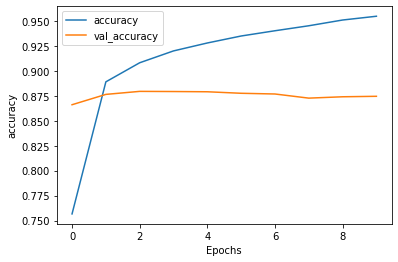

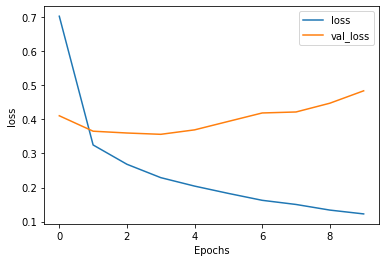

In [38]:
def plot_graphs(history, string):    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
 
y_pred = model.predict(X_validation_padded)
y_pred = y_pred.argmax(axis = 1)


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}


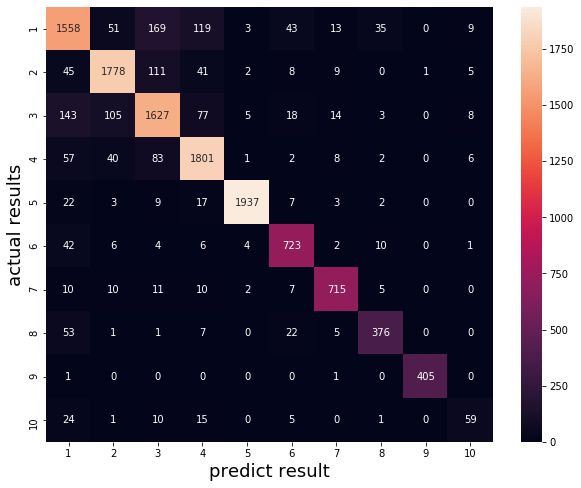

In [83]:
labels=[1,2,3,4,5,6,7,8,9,10] 
conf_mat = confusion_matrix(Y_validation_cat_seq, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('actual results',fontsize=18);
plt.xlabel('predict result',fontsize=18);
print(dict(list(label_word_index.items())))



In [81]:
from  sklearn.metrics import classification_report 
print('accuracy %s' % accuracy_score(y_pred, Y_validation_cat_seq))
print(classification_report(Y_validation_cat_seq, y_pred,target_names=[str(w) for w in labels]))
print(dict(list(label_word_index.items())))

accuracy 0.8744723217841497
              precision    recall  f1-score   support

           1       0.80      0.78      0.79      2000
           2       0.89      0.89      0.89      2000
           3       0.80      0.81      0.81      2000
           4       0.86      0.90      0.88      2000
           5       0.99      0.97      0.98      2000
           6       0.87      0.91      0.89       798
           7       0.93      0.93      0.93       770
           8       0.87      0.81      0.84       465
           9       1.00      1.00      1.00       407
          10       0.67      0.51      0.58       115

    accuracy                           0.87     12555
   macro avg       0.87      0.85      0.86     12555
weighted avg       0.87      0.87      0.87     12555

{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
